# Práctica 1

### Patricia Córdoba Hidalgo

Importamos las librerías que usaremos.

In [1]:
import pandas as pd
import numpy as np
import math as m

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from collections import Counter

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
from sklearn import tree

from mpl_toolkits.mplot3d import Axes3D

## Eliminación de atributo no predictivo y cuantificar las columnas categóricas

In [2]:
datos = pd.read_csv("mamografias.csv", na_values=["?"]) # Leemos los datos del csv

In [3]:
# En la documentación sale que hay un dato con BI-RADS = 55, compruebo si está para eliminarlo en caso positivo
# ya que se trataría de un dato con valores erróneos.
datos[datos['BI-RADS']==55.0].count() 

BI-RADS     0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

In [4]:
datos.info() # Vemos la cantidad de datos que poseemos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   959 non-null    float64
 1   Age       956 non-null    float64
 2   Shape     961 non-null    object 
 3   Margin    913 non-null    float64
 4   Density   885 non-null    float64
 5   Severity  961 non-null    object 
dtypes: float64(4), object(2)
memory usage: 45.2+ KB


In [5]:
datos.head() # Visualizamos algunos datos. Vemos que hay valores perdidos.

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,L,5.0,3.0,maligno
1,4.0,43.0,R,1.0,NaN,maligno
2,5.0,58.0,I,5.0,3.0,maligno
3,4.0,28.0,R,1.0,3.0,benigno
4,5.0,74.0,R,5.0,NaN,maligno


Convertimos los atributos categóricos en numéricos:

In [6]:
# Creamos un objeto Labelencoder
le = preprocessing.LabelEncoder()
# Convertimos las columnas categóricas en numéricas
encoded_value = le.fit_transform(["R","O","L","I", "N"])

for col in ['Shape']:
    datos[col] = le.fit_transform(datos[col])
    
print(encoded_value)

[4 3 1 0 2]


In [7]:
# Creamos un objeto Labelencoder
le = preprocessing.LabelEncoder()
# Convertimos las columnas categóricas en numéricas
encoded_value = le.fit_transform(["maligno", "benigno"])

for col in ['Severity']:
    datos[col] = le.fit_transform(datos[col])

print(encoded_value)

[1 0]


In [8]:
datos

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,1,5.0,3.0,1
1,4.0,43.0,4,1.0,NaN,1
2,5.0,58.0,0,5.0,3.0,1
3,4.0,28.0,4,1.0,3.0,0
4,5.0,74.0,4,5.0,NaN,1
...,...,...,...,...,...,...
956,4.0,47.0,3,1.0,3.0,0
957,4.0,56.0,0,5.0,3.0,1
958,4.0,64.0,0,5.0,3.0,0
959,5.0,66.0,0,5.0,3.0,1


Eliminamos la columna BI-RADS, que no es predictiva.

In [9]:
del(datos['BI-RADS'])

In [10]:
datos.head()

,Age,Shape,Margin,Density,Severity
0,67.0,1,5.0,3.0,1
1,43.0,4,1.0,NaN,1
2,58.0,0,5.0,3.0,1
3,28.0,4,1.0,3.0,0
4,74.0,4,5.0,NaN,1


## Preprocesado 1:

Eliminamos los datos con valores perdidos.

In [11]:
datos.isna().sum() # Total de valores perdidos que tenemos 

Age          5
Shape        0
Margin      48
Density     76
Severity     0
dtype: int64

In [12]:
p1_datos = datos.dropna() # Eliminamos los datos con valores perdidos

In [13]:
p1_datos.isna().sum()

Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

In [14]:
p1_datos.shape[0]

848

Ya no hay datos "perdidos".

### Separación entre datos y objetivo

In [15]:
# Separamos las columnas con los datos de la etiqueta a predecir
cols = [col for col in p1_datos.columns if col not in ['Severity']]
data = p1_datos[cols]
target = p1_datos['Severity']
data.head()

,Age,Shape,Margin,Density
0,67.0,1,5.0,3.0
2,58.0,0,5.0,3.0
3,28.0,4,1.0,3.0
8,57.0,4,5.0,3.0
9,60.0,2,5.0,1.0


In [16]:
target.head()

0    1
2    1
3    0
8    1
9    1
Name: Severity, dtype: int64

In [17]:
# Mostramos si los datos están o no balanceados (Para ver si accuracy es una buena medida)
malignos = 0
for i in target:
    if i == 1:
        malignos += 1

benignos = len(target) - malignos
print("Hay " + str(malignos) + " malignos y " + str(benignos) + " benignos.")

Hay 410 malignos y 438 benignos.


### Modelos:

In [18]:
def validacion_cruzada(clf, x, y, n):
    tn, tp, fn, fp = 0,0,0,0
    scaler = MinMaxScaler()

    # Creo los n conjuntos diferentes
    l = len(x)
    l = int(l/n)

    datos = []               #Vector de datos para training de cada iteración
    im_datos = []            #Vector de etiquetas para training de cada iteración
    datos_val = []           #Vector de datos para validación de cada iteración
    im_datos_val = []        #Vector de etiquetas para validación de cada iteración

    for i in range(0,n-1):
        aux_x = np.concatenate((x[:i*l], x[(i+1)*l:]), axis=0)
        aux_y = np.concatenate((y[:i*l], y[(i+1)*l:]), axis=0)
        
        datos.append(aux_x) #Valores de entrenamiento
        im_datos.append(aux_y)
        datos_val.append(x[i*l:(i+1)*l]) #Valores de validación
        im_datos_val.append(y[i*l:(i+1)*l])  
        
    #Última iteración, para usar todos los datos del test
    aux_x = x[:(n-1)*l]
    aux_y = y[:(n-1)*l]
        
    datos.append(aux_x) #Valores de entrenamiento
    im_datos.append(aux_y)
    datos_val.append(x[(n-1)*l:]) #Valores de validación
    im_datos_val.append(y[(n-1)*l:])
        
    # Realizo el ajuste con todos los conjuntos
    for i in range(0,n):
        datos[i] = scaler.fit_transform(datos[i])
        datos_val[i] = scaler.transform(datos_val[i])
        
        clf.fit(datos[i], im_datos[i])
        pred = clf.predict(datos_val[i])
        
        conf_mat = confusion_matrix(im_datos_val[i],pred)
        tn += conf_mat[0,0]
        tp += conf_mat[1,1]
        fn += conf_mat[1,0]
        fp += conf_mat[0,1]

    return tn, tp, fn, fp

In [19]:
# Función para visualizar matrices de confusión

# Matrix visualization
def visualizeMatrix(m, title='', conf=False):
    plt.matshow(m, cmap='viridis')
    plt.colorbar()
    plt.title(title,pad=20.0)
    if conf:
        plt.ylabel('Verdaderos')
        plt.xlabel('Predicciones')
    plt.show()

### ZeroR: 

In [20]:
dummy_clf = DummyClassifier(strategy="most_frequent")

tn,tp, fn, fp = validacion_cruzada(dummy_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
#ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
#Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
#print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
#print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 438
Verdaderos positivos (TP): 0
Falsos negativos (FN): 410
Falsos positivos (FP): 0

Accuracy: 0.5165094339622641
TPR: 0.0
TNR: 1.0
FPR: 0.0
FNR: 1.0
AUC: 0.5
Gmean: 0.0
F1- Score: 0.0


In [21]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'ZeroR:\nMatriz de confusión',True)

### Support Vector Machine (SVM):

In [22]:
svm_clf = LinearSVC(random_state=15, tol=1e-5)

tn,tp, fn, fp = validacion_cruzada(svm_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 321
Verdaderos positivos (TP): 350
Falsos negativos (FN): 60
Falsos positivos (FP): 117

Accuracy: 0.7912735849056604
TPR: 0.8536585365853658
TNR: 0.7328767123287672
FPR: 0.2671232876712329
FNR: 0.14634146341463414
PPV: 0.7494646680942184
AUC: 0.7932676244570664
Gmean: 0.7909655250035045
F1- Score: 0.798175598631699
Gmeasure: 0.7998668087799039


In [23]:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'SVM:\nMatriz de confusión',True)

### k-nn:

In [24]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 336
Verdaderos positivos (TP): 334
Falsos negativos (FN): 76
Falsos positivos (FP): 102

Accuracy: 0.7900943396226415
TPR: 0.8146341463414634
TNR: 0.7671232876712328
FPR: 0.2328767123287671
FNR: 0.18536585365853658
PPV: 0.7660550458715596
AUC: 0.790878717006348
Gmean: 0.7905218685088424
F1- Score: 0.789598108747045
Gmeasure: 0.7899712642521552


In [25]:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'K-nn:\nMatriz de confusión',True)

### Árbol de decisión:

In [26]:
tree_clf = DecisionTreeClassifier(random_state=15)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 332
Verdaderos positivos (TP): 284
Falsos negativos (FN): 126
Falsos positivos (FP): 106

Accuracy: 0.7264150943396226
TPR: 0.6926829268292682
TNR: 0.7579908675799086
FPR: 0.2420091324200913
FNR: 0.3073170731707317
PPV: 0.7282051282051282
AUC: 0.7253368972045885
Gmean: 0.7246014992153325
F1- Score: 0.71
Gmeasure: 0.7102219790581046


In [27]:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'Árbol de decisión:\nMatriz de confusión',True)

### Multilayer Perceptron (neural networks):

In [28]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(150,150),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 328
Verdaderos positivos (TP): 342
Falsos negativos (FN): 68
Falsos positivos (FP): 110

Accuracy: 0.7900943396226415
TPR: 0.8341463414634146
TNR: 0.7488584474885844
FPR: 0.2511415525114155
FNR: 0.16585365853658537
PPV: 0.7566371681415929
AUC: 0.7915023944759995
Gmean: 0.7903527910032173
F1- Score: 0.7935034802784223
Gmeasure: 0.7944470565245667


In [29]:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'MLP:\nMatriz de confusión',True)

### Random Forest:

In [30]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 327
Verdaderos positivos (TP): 322
Falsos negativos (FN): 88
Falsos positivos (FP): 111

Accuracy: 0.7653301886792453
TPR: 0.7853658536585366
TNR: 0.7465753424657534
FPR: 0.2534246575342466
FNR: 0.2146341463414634
PPV: 0.74364896073903
AUC: 0.765970598062145
Gmean: 0.76572500361163
F1- Score: 0.763938315539739
Gmeasure: 0.7642228083962764


In [31]:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'Random Forest:\nMatriz de confusión',True)

## Preprocesado 2:

Sustituimos los valores perdidos por la mediana si es cuantitativo y por la moda si es cualitativo.

In [32]:
p2_datos = datos.copy()

Para realizar operaciones con las columnas, como calcular la media, necesito que los datos sean de tipo numérico, por eso los cambiamos con astype al hacerlo.

In [33]:
# Rellenaremos los valores perdidos de Age con la mediana:
p2_datos[["Age"]] = p2_datos[["Age"]].fillna(int(p2_datos[["Age"]].median()))
print("Mediana de la edad: " + str(int(p2_datos[["Age"]].median())))

# Rellenaremos los valores perdidos de Margin con la moda:
p2_datos[["Margin"]] = p2_datos[["Margin"]].fillna(datos[["Margin"]].mode().iloc[0,0])
print("Moda del margen: " + str(p2_datos[["Margin"]].mode().iloc[0,0]))

# Rellenaremos los valores perdidos de Shape con la moda:
p2_datos[["Density"]] = p2_datos[["Density"]].fillna(p2_datos[["Density"]].mode().iloc[0,0])
print("Moda de la densidad: " + str(p2_datos[["Density"]].mode().iloc[0,0]))

Mediana de la edad: 57
Moda del margen: 1.0
Moda de la densidad: 3.0


In [34]:
p2_datos.isna().sum() # Ya no hay valores nulos

Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

### Separación entre datos y objetivo:

In [35]:
# Separamos las columnas con los datos de la etiqueta a predecir
cols = [col for col in p2_datos.columns if col not in ['Severity']]
data = p2_datos[cols]
target = p2_datos['Severity']
print("Datos")
print(data.head())
print()
print("Etiqueta")
print(target.head())

Datos
    Age  Shape  Margin  Density
0  67.0      1     5.0      3.0
1  43.0      4     1.0      3.0
2  58.0      0     5.0      3.0
3  28.0      4     1.0      3.0
4  74.0      4     5.0      3.0

Etiqueta
0    1
1    1
2    1
3    0
4    1
Name: Severity, dtype: int64


### Desempeño:

#### ZeroR:

In [36]:
dummy_clf = DummyClassifier(strategy="most_frequent")

tn,tp, fn, fp = validacion_cruzada(dummy_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
#ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
#Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
#print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
#print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 516
Verdaderos positivos (TP): 0
Falsos negativos (FN): 445
Falsos positivos (FP): 0

Accuracy: 0.5369406867845994
TPR: 0.0
TNR: 1.0
FPR: 0.0
FNR: 1.0
AUC: 0.5
Gmean: 0.0
F1- Score: 0.0


In [37]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'ZeroR:\nMatriz de confusión',True)

#### Support Vector Machine (SVM):

In [38]:
svm_clf = LinearSVC(random_state=15, tol=1e-5)

tn,tp, fn, fp = validacion_cruzada(svm_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 392
Verdaderos positivos (TP): 373
Falsos negativos (FN): 72
Falsos positivos (FP): 124

Accuracy: 0.7960457856399584
TPR: 0.8382022471910112
TNR: 0.7596899224806202
FPR: 0.24031007751937986
FNR: 0.16179775280898875
PPV: 0.7505030181086519
AUC: 0.7989460848358156
Gmean: 0.797981077589952
F1- Score: 0.7919320594479831
Gmeasure: 0.7931414226367882


In [39]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'SVM:\nMatriz de confusión',True)

#### K-nn:

In [40]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 410
Verdaderos positivos (TP): 349
Falsos negativos (FN): 96
Falsos positivos (FP): 106

Accuracy: 0.7898022892819979
TPR: 0.7842696629213484
TNR: 0.7945736434108527
FPR: 0.2054263565891473
FNR: 0.2157303370786517
PPV: 0.7670329670329671
AUC: 0.7894216531661006
Gmean: 0.7894048413102223
F1- Score: 0.7755555555555556
Gmeasure: 0.7756034337884966


In [41]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'k-nn:\nMatriz de confusión',True)

#### Árbol de decisión:

In [42]:
tree_clf = DecisionTreeClassifier(random_state=15)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 402
Verdaderos positivos (TP): 313
Falsos negativos (FN): 132
Falsos positivos (FP): 114

Accuracy: 0.7440166493236212
TPR: 0.7033707865168539
TNR: 0.7790697674418605
FPR: 0.22093023255813954
FNR: 0.2966292134831461
PPV: 0.7330210772833724
AUC: 0.7412202769793572
Gmean: 0.7402532776537257
F1- Score: 0.7178899082568807
Gmeasure: 0.71804290377542


In [43]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'Árbol de decisión:\nMatriz de confusión',True)

#### Multilayer Perceptron (MLP):

In [44]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(150,150),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 405
Verdaderos positivos (TP): 357
Falsos negativos (FN): 88
Falsos positivos (FP): 111

Accuracy: 0.7929240374609782
TPR: 0.802247191011236
TNR: 0.7848837209302325
FPR: 0.21511627906976744
FNR: 0.19775280898876405
PPV: 0.7628205128205128
AUC: 0.7935654559707344
Gmean: 0.7935179647536191
F1- Score: 0.7820372398685652
Gmeasure: 0.7822855064846893


In [45]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'MLP:\nMatriz de confusión',True)

#### Random Forest (RF):

In [46]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 397
Verdaderos positivos (TP): 343
Falsos negativos (FN): 102
Falsos positivos (FP): 119

Accuracy: 0.7700312174817898
TPR: 0.7707865168539326
TNR: 0.7693798449612403
FPR: 0.23062015503875968
FNR: 0.2292134831460674
PPV: 0.7424242424242424
AUC: 0.7700831809075865
Gmean: 0.7700828597204934
F1- Score: 0.7563395810363837
Gmeasure: 0.7564724686636662


In [47]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'RF:\nMatriz de confusión',True)

## Preprocesado 3:

Eliminamos la característica Densidad por su baja varianza y eliminamos los datos con valores perdidos.

In [48]:
p3_datos = datos.copy()

In [49]:
p3_datos[p3_datos['Density'] == 3.0].count()

Age         793
Shape       798
Margin      772
Density     798
Severity    798
dtype: int64

In [50]:
p3_datos.dtypes

Age         float64
Shape         int64
Margin      float64
Density     float64
Severity      int64
dtype: object

In [51]:
p3_datos['Density'].var()

0.14473758212541862

In [52]:
del(p3_datos['Density'])

In [53]:
p3_datos

,Age,Shape,Margin,Severity
0,67.0,1,5.0,1
1,43.0,4,1.0,1
2,58.0,0,5.0,1
3,28.0,4,1.0,0
4,74.0,4,5.0,1
...,...,...,...,...
956,47.0,3,1.0,0
957,56.0,0,5.0,1
958,64.0,0,5.0,0
959,66.0,0,5.0,1


In [54]:
p3_datos.isna().sum()

Age          5
Shape        0
Margin      48
Severity     0
dtype: int64

In [55]:
p3_datos = p3_datos.dropna()

In [56]:
p3_datos.isna().sum()

Age         0
Shape       0
Margin      0
Severity    0
dtype: int64

In [57]:
p3_datos.shape[0]

908

In [58]:
#p3_datos['Age'].min()
#p3_datos['Age'].max()

### Separación entre datos y objetivo

In [59]:
# Separamos las columnas con los datos de la etiqueta a predecir
cols = [col for col in p3_datos.columns if col not in ['Severity']]
data = p3_datos[cols]
target = p3_datos['Severity']
print("Datos")
print(data.head())
print()
print("Etiqueta")
print(target.head())

Datos
    Age  Shape  Margin
0  67.0      1     5.0
1  43.0      4     1.0
2  58.0      0     5.0
3  28.0      4     1.0
4  74.0      4     5.0

Etiqueta
0    1
1    1
2    1
3    0
4    1
Name: Severity, dtype: int64


In [60]:
# Mostramos si los datos están o no balanceados (Para ver si accuracy es una buena medida)
malignos = 0
for i in target:
    if i == 1:
        malignos += 1

benignos = len(target) - malignos
print("Hay " + str(malignos) + " malignos y " + str(benignos) + " benignos.")

Hay 429 malignos y 479 benignos.


### Modelos:

### ZeroR:

In [61]:
dummy_clf = DummyClassifier(strategy="most_frequent")

tn,tp, fn, fp = validacion_cruzada(dummy_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
#ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
#Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
#print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
#print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 479
Verdaderos positivos (TP): 0
Falsos negativos (FN): 429
Falsos positivos (FP): 0

Accuracy: 0.5275330396475771
TPR: 0.0
TNR: 1.0
FPR: 0.0
FNR: 1.0
AUC: 0.5
Gmean: 0.0
F1- Score: 0.0


[[0.5275330396475771, 0.0], [0.4724669603524229, 0.0]]


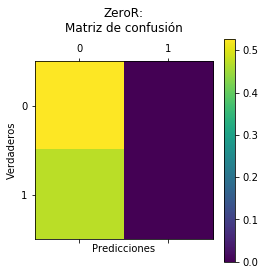

In [62]:
# Matriz de confusión:
conf_mat = [[tn/len(data), fp/len(data)],[fn/len(data), tp/len(data)]]
print(conf_mat)
visualizeMatrix(conf_mat,'ZeroR:\nMatriz de confusión',True)

### Support Vector Machine (SVM):

In [63]:
svm_clf = LinearSVC(random_state=15, tol=1e-5)

tn,tp, fn, fp = validacion_cruzada(svm_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 360
Verdaderos positivos (TP): 365
Falsos negativos (FN): 64
Falsos positivos (FP): 119

Accuracy: 0.7984581497797357
TPR: 0.8508158508158508
TNR: 0.7515657620041754
FPR: 0.24843423799582465
FNR: 0.14918414918414918
PPV: 0.7541322314049587
AUC: 0.8011908064100131
Gmean: 0.7996524640390009
F1- Score: 0.7995618838992333
Gmeasure: 0.8010166390846484


[[0.3964757709251101, 0.13105726872246695], [0.07048458149779736, 0.40198237885462557]]


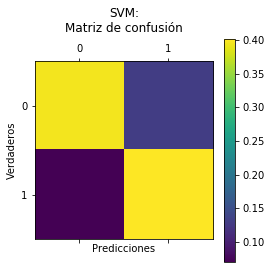

In [64]:
# Matriz de confusión:
conf_mat = [[tn/len(data), fp/len(data)],[fn/len(data), tp/len(data)]]
print(conf_mat)
visualizeMatrix(conf_mat,'SVM:\nMatriz de confusión',True)

### k-nn:

In [65]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 369
Verdaderos positivos (TP): 347
Falsos negativos (FN): 82
Falsos positivos (FP): 110

Accuracy: 0.788546255506608
TPR: 0.8088578088578089
TNR: 0.7703549060542797
FPR: 0.22964509394572025
FNR: 0.19114219114219114
PPV: 0.7592997811816192
AUC: 0.7896063574560443
Gmean: 0.7893716370341208
F1- Score: 0.7832957110609481
Gmeasure: 0.7836871552301838


In [66]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'k-nn:\nMatriz de confusión',True)

### Árbol de decisión:

In [67]:
tree_clf = DecisionTreeClassifier(random_state=15)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 376
Verdaderos positivos (TP): 304
Falsos negativos (FN): 125
Falsos positivos (FP): 103

Accuracy: 0.748898678414097
TPR: 0.7086247086247086
TNR: 0.7849686847599165
FPR: 0.2150313152400835
FNR: 0.2913752913752914
PPV: 0.7469287469287469
AUC: 0.7467966966923125
Gmean: 0.7458204914840545
F1- Score: 0.7272727272727273
Gmeasure: 0.7275246838807615


In [68]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'Árbol de decisión:\nMatriz de confusión',True)

### Multilayer Perceptron (MLP):

In [69]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(150,150),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 363
Verdaderos positivos (TP): 360
Falsos negativos (FN): 69
Falsos positivos (FP): 116

Accuracy: 0.7962555066079295
TPR: 0.8391608391608392
TNR: 0.7578288100208769
FPR: 0.24217118997912318
FNR: 0.16083916083916083
PPV: 0.7563025210084033
AUC: 0.798494824590858
Gmean: 0.7974586259846834
F1- Score: 0.7955801104972375
Gmeasure: 0.7966551689337551


In [70]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'MLP:\nMatriz de confusión',True)

### Random Forest (RF):

In [71]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 367
Verdaderos positivos (TP): 334
Falsos negativos (FN): 95
Falsos positivos (FP): 112

Accuracy: 0.7720264317180616
TPR: 0.7785547785547785
TNR: 0.7661795407098121
FPR: 0.23382045929018788
FNR: 0.22144522144522144
PPV: 0.7488789237668162
AUC: 0.7723671596322954
Gmean: 0.7723423739835396
F1- Score: 0.7634285714285715
Gmeasure: 0.7635726976900199


In [72]:
# Matriz de confusión:
#conf_mat = [[tn, fp],[fn, tp]]
#print(conf_mat)
#visualizeMatrix(conf_mat,'RF:\nMatriz de confusión',True)

El preprocesado con mejores resultados es 3. Es el que usaremos a partir de ahora.

## Selección de hiperparámetros:

Seleccionamos los hiperparámetros que usarán algunos de nuestros modelos

### k-nn:

In [73]:
knn_clf = KNeighborsClassifier(n_neighbors=1)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 360
Verdaderos positivos (TP): 297
Falsos negativos (FN): 132
Falsos positivos (FP): 119

Accuracy: 0.723568281938326
TPR: 0.6923076923076923
TNR: 0.7515657620041754
FPR: 0.24843423799582465
FNR: 0.3076923076923077
PPV: 0.7139423076923077
AUC: 0.7219367271559338
Gmean: 0.7213284676973334
F1- Score: 0.7029585798816568
Gmeasure: 0.7030417850165734


In [74]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 369
Verdaderos positivos (TP): 347
Falsos negativos (FN): 82
Falsos positivos (FP): 110

Accuracy: 0.788546255506608
TPR: 0.8088578088578089
TNR: 0.7703549060542797
FPR: 0.22964509394572025
FNR: 0.19114219114219114
PPV: 0.7592997811816192
AUC: 0.7896063574560443
Gmean: 0.7893716370341208
F1- Score: 0.7832957110609481
Gmeasure: 0.7836871552301838


In [75]:
knn_clf = KNeighborsClassifier(n_neighbors=9)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 377
Verdaderos positivos (TP): 354
Falsos negativos (FN): 75
Falsos positivos (FP): 102

Accuracy: 0.8050660792951542
TPR: 0.8251748251748252
TNR: 0.7870563674321504
FPR: 0.21294363256784968
FNR: 0.17482517482517482
PPV: 0.7763157894736842
AUC: 0.8061155963034877
Gmean: 0.805890253321479
F1- Score: 0.8
Gmeasure: 0.8003725669083142


La matriz de confusión del modelo con mayor F1-Score:

[[0.41519823788546256, 0.11233480176211454], [0.08259911894273128, 0.3898678414096916]]


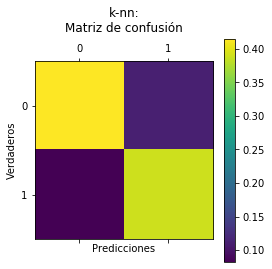

In [76]:
# Matriz de confusión:
conf_mat = [[tn/len(data), fp/len(data)],[fn/len(data), tp/len(data)]]
print(conf_mat)
visualizeMatrix(conf_mat,'k-nn:\nMatriz de confusión',True)

### Árbol de decisión

Criterio para dividir una rama:

In [77]:
tree_clf = DecisionTreeClassifier(random_state=15)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 376
Verdaderos positivos (TP): 304
Falsos negativos (FN): 125
Falsos positivos (FP): 103

Accuracy: 0.748898678414097
TPR: 0.7086247086247086
TNR: 0.7849686847599165
FPR: 0.2150313152400835
FNR: 0.2913752913752914
PPV: 0.7469287469287469
AUC: 0.7467966966923125
Gmean: 0.7458204914840545
F1- Score: 0.7272727272727273
Gmeasure: 0.7275246838807615


In [78]:
tree_clf = DecisionTreeClassifier(random_state=15, criterion = "entropy")

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 375
Verdaderos positivos (TP): 302
Falsos negativos (FN): 127
Falsos positivos (FP): 104

Accuracy: 0.7455947136563876
TPR: 0.703962703962704
TNR: 0.7828810020876826
FPR: 0.21711899791231734
FNR: 0.29603729603729606
PPV: 0.7438423645320197
AUC: 0.7434218530251933
Gmean: 0.7423739132746223
F1- Score: 0.7233532934131737
Gmeasure: 0.7236278617203541


Parámetro de poda:

In [79]:
tree_clf = DecisionTreeClassifier(random_state=15, ccp_alpha = 0.002)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 378
Verdaderos positivos (TP): 357
Falsos negativos (FN): 72
Falsos positivos (FP): 101

Accuracy: 0.8094713656387665
TPR: 0.8321678321678322
TNR: 0.7891440501043842
FPR: 0.21085594989561587
FNR: 0.16783216783216784
PPV: 0.7794759825327511
AUC: 0.8106559411361081
Gmean: 0.8103704667888068
F1- Score: 0.8049605411499436
Gmeasure: 0.8053911090961773


In [80]:
tree_clf = DecisionTreeClassifier(random_state=15, ccp_alpha = 0.003)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 378
Verdaderos positivos (TP): 358
Falsos negativos (FN): 71
Falsos positivos (FP): 101

Accuracy: 0.8105726872246696
TPR: 0.8344988344988346
TNR: 0.7891440501043842
FPR: 0.21085594989561587
FNR: 0.1655011655011655
PPV: 0.7799564270152506
AUC: 0.8118214423016092
Gmean: 0.8115046457438173
F1- Score: 0.8063063063063063
Gmeasure: 0.8067668370130876


Árbol de decisión con mayor F1-Score:

[[0.41629955947136565, 0.11123348017621146], [0.07819383259911894, 0.394273127753304]]


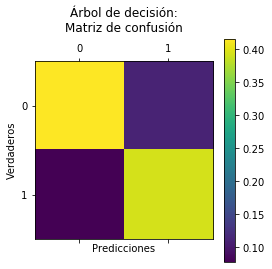

In [81]:
# Matriz de confusión:
conf_mat = [[tn/len(data), fp/len(data)],[fn/len(data), tp/len(data)]]
print(conf_mat)
visualizeMatrix(conf_mat,'Árbol de decisión:\nMatriz de confusión',True)

In [82]:
tree_clf = DecisionTreeClassifier(random_state=15, ccp_alpha = 0.004)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 366
Verdaderos positivos (TP): 362
Falsos negativos (FN): 67
Falsos positivos (FP): 113

Accuracy: 0.801762114537445
TPR: 0.8438228438228438
TNR: 0.7640918580375783
FPR: 0.2359081419624217
FNR: 0.1561771561771562
PPV: 0.7621052631578947
AUC: 0.8039573509302111
Gmean: 0.8029683459459345
F1- Score: 0.8008849557522124
Gmeasure: 0.8019238308282474


### Multilayer Peerceptron (MLP):

Número de capas y neuronas por capa:

In [83]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(130,130),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 366
Verdaderos positivos (TP): 351
Falsos negativos (FN): 78
Falsos positivos (FP): 113

Accuracy: 0.789647577092511
TPR: 0.8181818181818182
TNR: 0.7640918580375783
FPR: 0.2359081419624217
FNR: 0.18181818181818182
PPV: 0.7564655172413793
AUC: 0.7911368381096984
Gmean: 0.7906744372161715
F1- Score: 0.786114221724524
Gmeasure: 0.7867187123034518


In [84]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(140,140),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 371
Verdaderos positivos (TP): 349
Falsos negativos (FN): 80
Falsos positivos (FP): 108

Accuracy: 0.7929515418502202
TPR: 0.8135198135198135
TNR: 0.7745302713987474
FPR: 0.2254697286012526
FNR: 0.1864801864801865
PPV: 0.7636761487964989
AUC: 0.7940250424592805
Gmean: 0.7937856901921069
F1- Score: 0.7878103837471784
Gmeasure: 0.7882040840787727


In [85]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(150,150),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 363
Verdaderos positivos (TP): 360
Falsos negativos (FN): 69
Falsos positivos (FP): 116

Accuracy: 0.7962555066079295
TPR: 0.8391608391608392
TNR: 0.7578288100208769
FPR: 0.24217118997912318
FNR: 0.16083916083916083
PPV: 0.7563025210084033
AUC: 0.798494824590858
Gmean: 0.7974586259846834
F1- Score: 0.7955801104972375
Gmeasure: 0.7966551689337551


MLP con mayor F1-Score:

[[0.3997797356828194, 0.1277533039647577], [0.07599118942731277, 0.3964757709251101]]


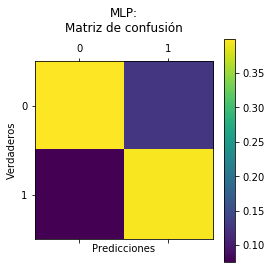

In [86]:
# Matriz de confusión:
conf_mat = [[tn/len(data), fp/len(data)],[fn/len(data), tp/len(data)]]
print(conf_mat)
visualizeMatrix(conf_mat,'MLP:\nMatriz de confusión',True)

### Random Forest (RF):

Criterio de división:

In [87]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 367
Verdaderos positivos (TP): 334
Falsos negativos (FN): 95
Falsos positivos (FP): 112

Accuracy: 0.7720264317180616
TPR: 0.7785547785547785
TNR: 0.7661795407098121
FPR: 0.23382045929018788
FNR: 0.22144522144522144
PPV: 0.7488789237668162
AUC: 0.7723671596322954
Gmean: 0.7723423739835396
F1- Score: 0.7634285714285715
Gmeasure: 0.7635726976900199


In [88]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150, criterion = "entropy")

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 366
Verdaderos positivos (TP): 335
Falsos negativos (FN): 94
Falsos positivos (FP): 113

Accuracy: 0.7720264317180616
TPR: 0.7808857808857809
TNR: 0.7640918580375783
FPR: 0.2359081419624217
FNR: 0.2191142191142191
PPV: 0.7477678571428571
AUC: 0.7724888194616797
Gmean: 0.7724431805849162
F1- Score: 0.7639680729760547
Gmeasure: 0.7641474249425217


Número de estimadores:

In [89]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150, criterion = "entropy")

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 366
Verdaderos positivos (TP): 335
Falsos negativos (FN): 94
Falsos positivos (FP): 113

Accuracy: 0.7720264317180616
TPR: 0.7808857808857809
TNR: 0.7640918580375783
FPR: 0.2359081419624217
FNR: 0.2191142191142191
PPV: 0.7477678571428571
AUC: 0.7724888194616797
Gmean: 0.7724431805849162
F1- Score: 0.7639680729760547
Gmeasure: 0.7641474249425217


In [90]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=160, criterion = "entropy")

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 367
Verdaderos positivos (TP): 335
Falsos negativos (FN): 94
Falsos positivos (FP): 112

Accuracy: 0.7731277533039648
TPR: 0.7808857808857809
TNR: 0.7661795407098121
FPR: 0.23382045929018788
FNR: 0.2191142191142191
PPV: 0.7494407158836689
AUC: 0.7735326607977966
Gmean: 0.7734977110152884
F1- Score: 0.7648401826484018
Gmeasure: 0.7650016984624396


In [91]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=170, criterion = "entropy")

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 366
Verdaderos positivos (TP): 335
Falsos negativos (FN): 94
Falsos positivos (FP): 113

Accuracy: 0.7720264317180616
TPR: 0.7808857808857809
TNR: 0.7640918580375783
FPR: 0.2359081419624217
FNR: 0.2191142191142191
PPV: 0.7477678571428571
AUC: 0.7724888194616797
Gmean: 0.7724431805849162
F1- Score: 0.7639680729760547
Gmeasure: 0.7641474249425217


Parámetro de poda:

In [92]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=160, criterion = "entropy", ccp_alpha= 0.006)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 377
Verdaderos positivos (TP): 356
Falsos negativos (FN): 73
Falsos positivos (FP): 102

Accuracy: 0.8072687224669604
TPR: 0.8298368298368298
TNR: 0.7870563674321504
FPR: 0.21294363256784968
FNR: 0.17016317016317017
PPV: 0.777292576419214
AUC: 0.80844659863449
Gmean: 0.8081635730796005
F1- Score: 0.8027057497181511
Gmeasure: 0.8031351115917061


In [93]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=160, criterion = "entropy", ccp_alpha= 0.008)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 374
Verdaderos positivos (TP): 363
Falsos negativos (FN): 66
Falsos positivos (FP): 105

Accuracy: 0.8116740088105727
TPR: 0.8461538461538461
TNR: 0.7807933194154488
FPR: 0.21920668058455114
FNR: 0.15384615384615385
PPV: 0.7756410256410257
AUC: 0.8134735827846475
Gmean: 0.8128168737634638
F1- Score: 0.8093645484949833
Gmeasure: 0.8101306296399784


RF con mayor F1-Score:

[[0.4118942731277533, 0.11563876651982379], [0.07268722466960352, 0.3997797356828194]]


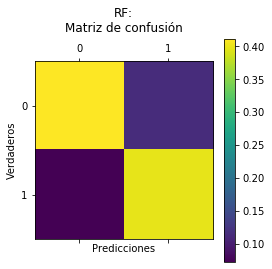

In [94]:
# Matriz de confusión:
conf_mat = [[tn/len(data), fp/len(data)],[fn/len(data), tp/len(data)]]
print(conf_mat)
visualizeMatrix(conf_mat,'RF:\nMatriz de confusión',True)

In [95]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=160, criterion = "entropy", ccp_alpha= 0.01)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 373
Verdaderos positivos (TP): 363
Falsos negativos (FN): 66
Falsos positivos (FP): 106

Accuracy: 0.8105726872246696
TPR: 0.8461538461538461
TNR: 0.778705636743215
FPR: 0.22129436325678498
FNR: 0.15384615384615385
PPV: 0.7739872068230277
AUC: 0.8124297414485306
Gmean: 0.811729492843491
F1- Score: 0.8084632516703786
Gmeasure: 0.8092664900557648


### Visualización del árbol de decisión:

In [96]:
tree_clf = DecisionTreeClassifier(random_state=15, ccp_alpha = 0.003)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
ppv = tp/(tp+fp)
auc = (1+tpr-fpr)/2
Gmean = m.sqrt(tpr*tnr)
f1 = (2*tp)/(2*tp+fp+fn)
Gmeasure = m.sqrt(ppv*tpr)


print("Verdaderos negativos (TN): " + str(tn))
print("Verdaderos positivos (TP): " + str(tp))
print("Falsos negativos (FN): " + str(fn))
print("Falsos positivos (FP): " + str(fp))
print()
print("Accuracy: " + str(accuracy))
print("TPR: " + str(tpr))
print("TNR: " + str(tnr))
print("FPR: " + str(fpr))
print("FNR: " + str(fnr))
print("PPV: " + str(ppv))
print("AUC: " + str(auc))
print("Gmean: " + str(Gmean))
print("F1- Score: " + str(f1))
print("Gmeasure: " + str(Gmeasure))

Verdaderos negativos (TN): 378
Verdaderos positivos (TP): 358
Falsos negativos (FN): 71
Falsos positivos (FP): 101

Accuracy: 0.8105726872246696
TPR: 0.8344988344988346
TNR: 0.7891440501043842
FPR: 0.21085594989561587
FNR: 0.1655011655011655
PPV: 0.7799564270152506
AUC: 0.8118214423016092
Gmean: 0.8115046457438173
F1- Score: 0.8063063063063063
Gmeasure: 0.8067668370130876


In [97]:
data.shape[0]

908

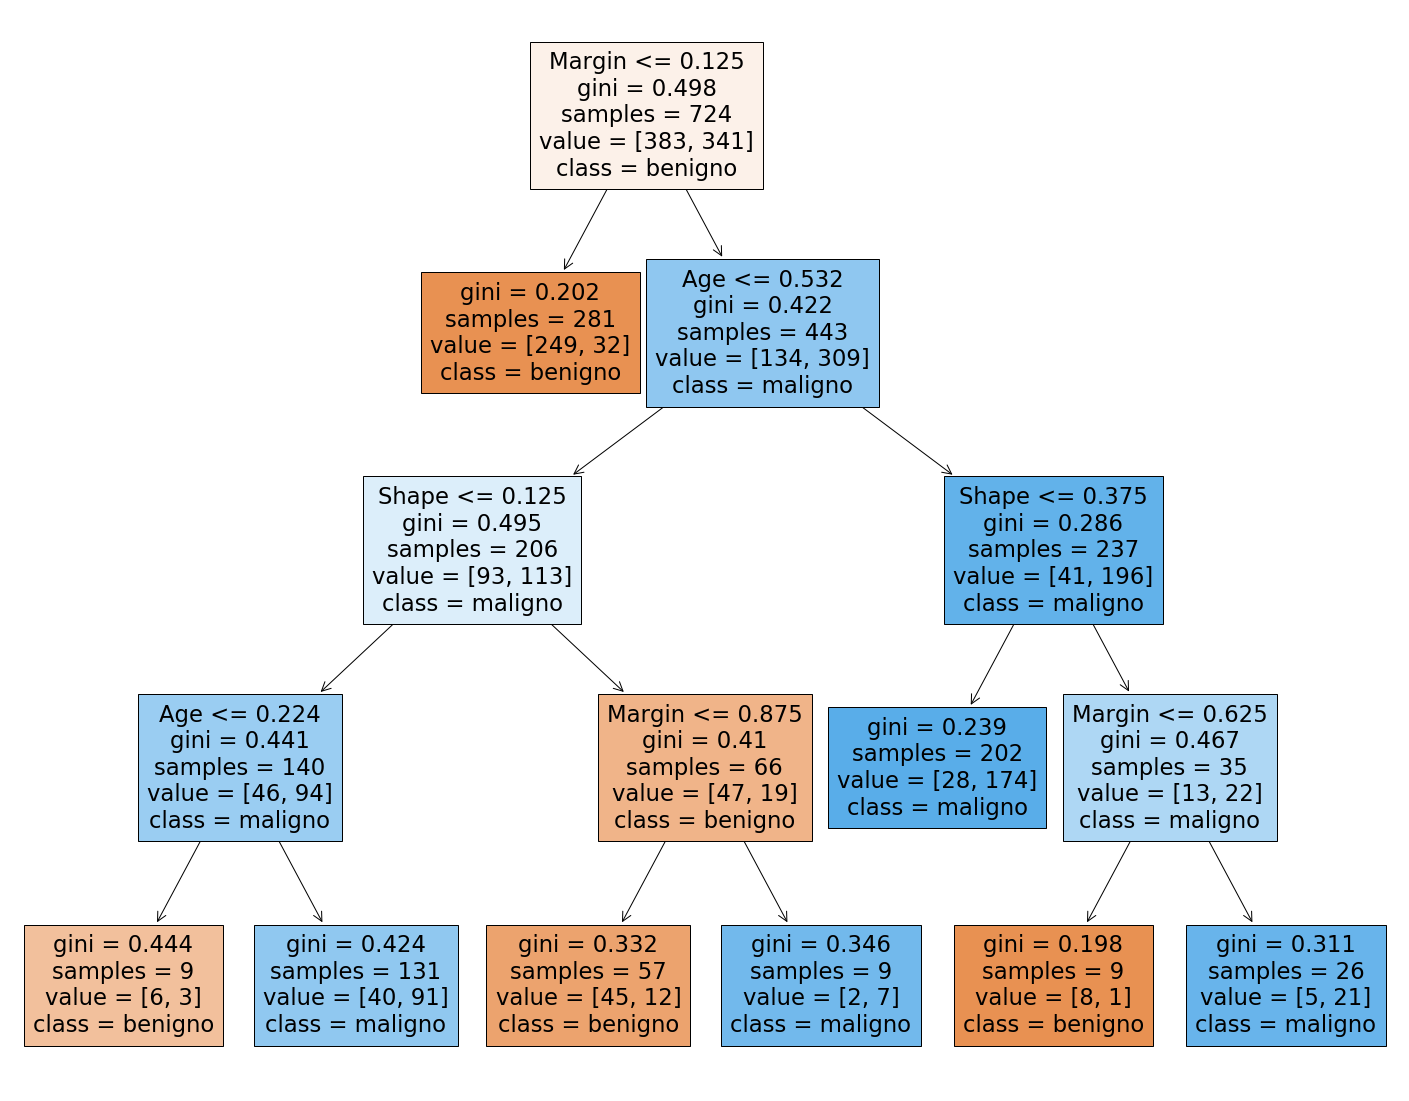

In [98]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_clf, 
                   feature_names=data.columns,  
                   class_names=["benigno","maligno"],
                   filled=True)


### Visualización de los datos:

In [99]:
def dibuja_grafica(datos, target):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        #Ponemos nombre a los ejes
        ax.set_xlabel('Age', fontsize = 10)
        ax.set_ylabel('Shape', fontsize = 10)
        ax.set_zlabel('Margin', fontsize = 10)

        #Datos con etiqueta 1
        azul_x = [] #Coordenada X
        azul_y = [] #Coordenada Y
        azul_z = [] #Coordenada Z
        
        #Datos con etiqueta -1
        rosa_x = [] #Coordenada X
        rosa_y = [] #Coordenada Y
        rosa_z = [] #Coordenada Z

        #Guardamos en vectores los distintos valores
        for i in range(0, len(datos)):
                if target.iloc[i] == 1:
                        azul_x.append(datos['Age'].iloc[i])
                        azul_y.append(datos['Shape'].iloc[i])
                        azul_z.append(datos['Margin'].iloc[i])
                else:
                        rosa_x.append(datos['Age'].iloc[i])
                        rosa_y.append(datos['Shape'].iloc[i])
                        rosa_z.append(datos['Margin'].iloc[i])

        #Pintamos los datos de entrenamiento
        ax.scatter(azul_x, azul_y, azul_z, c='c')
        ax.scatter(rosa_x, rosa_y, rosa_z, c='m')
        
        plt.show() 

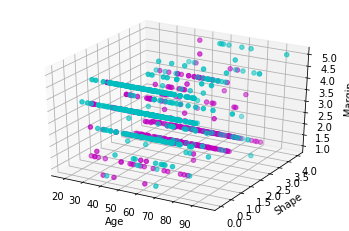

In [100]:
dibuja_grafica(data,target)